In this notebook, I extract the broadband flux time series as well as the spectrophometric time series (i.e. the raw transmission spectrum) from our HST data. 

In [1]:
# Importing modules we need:
import numpy as np
import matplotlib.pyplot as plt
import astropy
import astropy.convolution as ac
from astropy.io import fits
# Importing HST extraction functions
import HST_Extract_Funcs as hst
import HST_extraction as ext

I've placed the data in a separate directory off my home directory. Thomas' file structure that loads in the data, however, needs the data held in a directory that branches from the present working directory. Therefore, I'll need to edit this file structure to find where I've placed the data.

If the below block of code is commented out, then I've already done this so skip to next block to load in the new file path structure

In [2]:
# # Load in Thomas' file structure
# FSload = np.load('T_FileStructure.npz', allow_pickle=True)
# data_dict = FSload['filedict'].item()   # dictionary containing paths to the image files

# # Make a deep copy that I can edit
# import copy
# ddcopy = copy.deepcopy(data_dict)
# # Now to edit the paths within the copy dictionary
# for visit in data_dict:
#     # Go through each visit
#     for orbit in data_dict[visit]:
#         # Go through each orbit in that visit
#         #
#         # Each orbit has only one direct image
#         # First, edit this direct image's path
#         oldpath = data_dict[visit][orbit]['direct']
#         newpath = oldpath.replace('./Data/', '/home/matthew/data/hd219666b/hst_images/')
#         ddcopy[visit][orbit]['direct'] = newpath
#         # Now looping through this orbit's grism images and editing their paths
#         grismpaths = data_dict[visit][orbit]['grism']
#         for i, oldpath in enumerate(grismpaths):
#             newpath = oldpath.replace('./Data/', '/home/matthew/data/hd219666b/hst_images/')
#             ddcopy[visit][orbit]['grism'][i] = newpath
            
# # Saving this edited dictionary as the new file structure dictionary
# np.savez('FilePaths.npz', filedict=ddcopy)

Loading in the dictionary containing the file paths to our data

In [2]:
FPload = np.load('FilePaths.npz', allow_pickle=True)
datapaths = FPload['filedict'].item()   # dictionary containing paths to the image files

On orbit  orbit1
Working on image  0


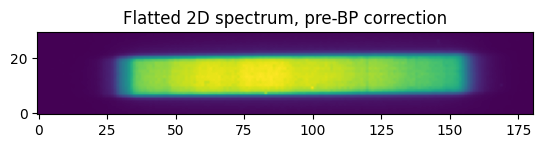

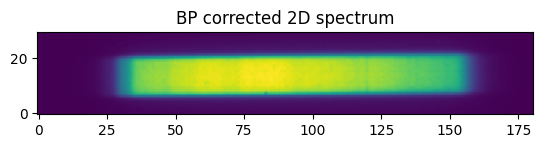

/home/matthew/inquiry/hd219666b/reduction/HST_extraction.py:336: RuntimeWarning: invalid value encountered in sqrt
  spec2D_photnoise = np.sqrt(spec2D)


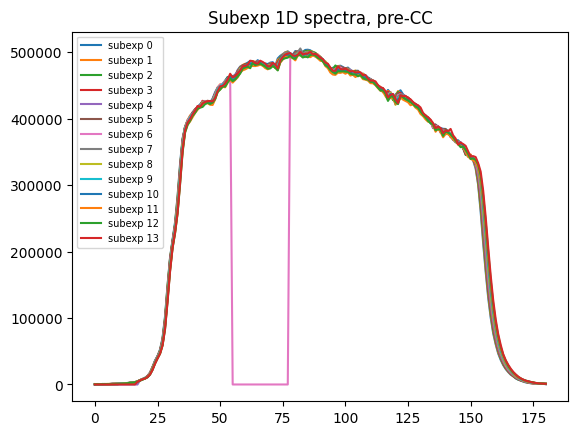

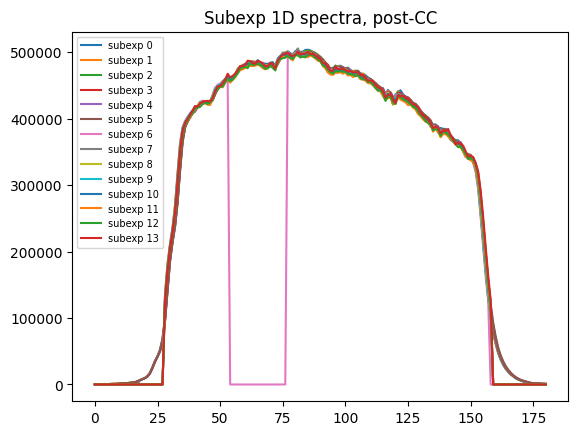

In [15]:
for orbit in datapaths['visit3']:
    # Going through each orbit in the visit
    #    reminder: we're only using visit 3's data
    if orbit != 'orbit1':
        continue
    print('On orbit ', orbit)
    
    ######################################################
    # STEP 1 - Load in the direct image for this orbit
    #          and compute the wavelength solution
    direct_image_path = datapaths['visit3'][orbit]['direct']
    # compute the parameters of the wavelength solution:
    wavesolution = hst.WavelengthSolution(direct_image_path) 
    # find the start & end values of the pixel range over which our spectrum is placed on the image
    min_wavelength = 9708   # Min wavelength of response function, [Angstrom]
    max_wavelength = 17904
    extractrange = hst.GetExtractRange(min_wavelength, max_wavelength, direct_image_path, 0)
    
    ######################################################
    # STEP 2 - Go through each grism exposure in this orbit
    # Creating some arrays to contain the data of each grism exposure
    Nimages = len(datapaths['visit3'][orbit]['grism'])
    image_1Dspectra = [ [] for _ in range(Nimages)]        # 1D spectra of each image
    image_1Dspectra_uncs = [ [] for _ in range(Nimages)]   # 1D spectral errors of each image
    image_broadbands = np.zeros(Nimages)                   # Band-integrated flux of each image
    image_broadbands_uncs = np.zeros(Nimages)              # Band-integrated flux error of each image
    for image in range(Nimages):
        if image != 0:
            continue
        print('Working on image ',image)
        
        ###################################################
        # STEP 3 - Separate out each sub-exposure within this image
        subexp_details = hst.CreateSubExps(datapaths['visit3'][orbit]['grism'][image], wavesolution)
        subexp_images = subexp_details[0]        # Array containing each sub-exposure's image array
        subexp_times = subexp_details[1]         # Array containing the time of each sub exposure [BJD TDB]
        subexp_badpixmasks = subexp_details[2]   # Array containing each sub-exposure's bad pixel mask
        subexp_dataqualities = subexp_details[3] # Array containing DQ flags on each sub-exposure
        subexp_scandirs = subexp_details[4]      # Array containing the scan direction of each sub-exposure
        subexp_shifts = subexp_details[6]        # Array containing angular shifting of each sub-exposure
        Nsubexps = subexp_images.shape[0]        # Number of sub-exposures in this image
        
        ###################################################
        # STEP 4 - Subtract out the background flux on each sub-exposure image
        bksub_details = hst.BkgdSub(subexp_images, subexp_badpixmasks, subexp_scandirs)
        bsub_subexp_images = bksub_details[0]  # each background subtracted sub-exposure image
        bsub_subexp_bkvals = bksub_details[1]  # background values of each sub-exposure
        bsub_subexp_bkerrs = bksub_details[2]  # uncertainty on above
        
        #*#*#*
        # note: here, I can add in function to set negative pixels to zero
        # will skip for now
        #*#*#*
        
        ###################################################
        # STEP 5 - Flat-field each background subtracted sub-exposure image
        # Path to the appropriate flat-field calibration image:
        flatimg = '/home/matthew/data/hd219666b/calibrations/WFC3.IR.G141.flat.2.fits'
        flat_subexp_images = hst.FlatField(flatimg, bsub_subexp_images, wavesolution, subexp_shifts)
        
        
        ###################################################
        # STEP 6a - Extract the 2D target spectrum
        twoDspectra, boxCoords = ext.cutout2Dspectrum(flat_subexp_images, extractrange, 15, 5, returnCoords=True)
        plt.imshow(twoDspectra[6], origin='lower')
        plt.title('Flatted 2D spectrum, pre-BP correction')
        plt.show()
        
        # STEP 6b - Extract the 2D data quality array
        DQspectra = np.zeros(twoDspectra.shape)
        for i in range(DQspectra.shape[0]):
            coords = boxCoords[i]
            DQspectra[i] = subexp_dataqualities[i, coords[0]:coords[1], coords[2]:coords[3]]

        ###################################################
        # Step 7 - Bad pixel correction
        twoDspectra_corr = ext.CorrectBadPixels(twoDspectra, DQspectra, Niter=5)
        plt.imshow(twoDspectra_corr[6], origin='lower')
        plt.title('BP corrected 2D spectrum')
        plt.show()
             
        ##################################################
        # STEP 8 - Fitting the spectral trace
        disp_axis, traces = ext.FitSpectralTrace(twoDspectra_corr)
        
        ##################################################
        # Step 9 - Extracting the 1D spectra
        oneDspectra, oneDerrors = ext.Extract1D(twoDspectra_corr, traces, extractionheight=14)
        
        for i in range(oneDspectra.shape[0]):
            y = oneDspectra[i]
            x = np.arange(len(y))
            plt.plot(x, y, label='subexp %d'%(i))
        plt.legend(loc='best', fontsize=7)
        plt.title('Subexp 1D spectra, pre-CC')
        plt.show()
        
        #####################################################
        # STEP 10 - Cross-correlating the 1D spectra to correct for shifting
        subexp_1Dspecshifts = np.zeros(oneDspectra.shape[0], dtype=int)
        for i in range(oneDspectra.shape[0]):
            if i == 0:
                continue
            # we assume the first sub-exposure is correct
            # finding the shift
            spec_shift = ext.crosscorrelate(oneDspectra[0], oneDspectra[i], guesslimits=5, yzerolevel=100000.)[0]
            subexp_1Dspecshifts[i] = spec_shift

        # if there were shifts, here we correct them
        # we'll do this recursively until no shifts are detected
        shift_checks = np.copy(subexp_1Dspecshifts)
        while len(np.where(shift_checks != 0)[0]) != 0:
            toshift_idxs = np.where(subexp_1Dspecshifts != 0)[0]
            for idx in toshift_idxs:
                # un-shifting it
                oneDspectra[idx] = ext.shift(oneDspectra[idx], -subexp_1Dspecshifts[idx], 
                                              yzerolevel=100000.)
                # checking the new shift
                # if it's non-zero, this spectrum will go through the loop again
                shift_checks[idx] = ext.crosscorrelate(oneDspectra[0], oneDspectra[idx], guesslimits=5, yzerolevel=100000.)
    
        for i in range(oneDspectra.shape[0]):
            y = oneDspectra[i]
            x = np.arange(len(y))
            plt.plot(x, y, label='subexp %d'%(i))
        plt.legend(loc='best', fontsize=7)
        plt.title('Subexp 1D spectra, post-CC')
        plt.show()
        
        ####################################################
        # STEP 11 - Combining the 1D spectra subexposures into the image 1D spectrum
        # we'll do this just by summing the shift-corrected spectra at each dispersion pixel
        # since they've been shifted already, the dispersion pixels should already line up
        # so sum axis = the N subexposure axis
        oneDspectrum_img = np.sum(oneDspectra, axis=0)
        temp_sqr = oneDspectra**2
        oneDerror_img = np.sqrt(np.sum(temp_sqr, axis=0))
        del temp_sqr
        
        #######################################################
        # STEP 12 - Getting the image broadband flux value
        broadband_img = np.sum(oneDspectrum_img)
        temp_sqr2 = oneDspectrum_img**2
        broaderr_img = np.sqrt(np.sum(temp_sqr2))
        del temp_sqr2

In [8]:
oneDspectra.shape

(14, 181)

In [12]:
oneDspectra

array([[ 504.17279092,  194.20222533,  459.09598725, ...,  945.91976694,
         880.41948136,  899.7103098 ],
       [ 225.89401579,  264.41135399,  425.44351295, ..., 1118.80323762,
         804.56557849,  719.85696116],
       [   0.        ,    0.        ,    0.        , ..., 1162.53612235,
        1007.23592813,  638.32727682],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [11]:
oneDspectra**2

array([[ 254190.20310329,   37714.50432398,  210769.12551157, ...,
         894764.20548798,  775138.46316216,  809478.64155636],
       [  51028.1063715 ,   69913.36411763,  181002.18271338, ...,
        1251720.68450574,  647325.77009578,  518194.0445283 ],
       [      0.        ,       0.        ,       0.        , ...,
        1351490.235777  , 1014524.21490973,  407461.71233127],
       ...,
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ]])

In [10]:
np.sqrt(oneDspectra[:])

array([[22.45379235, 13.93564585, 21.42652532, ..., 30.75580867,
        29.67186346, 29.99517144],
       [15.02977098, 16.26073043, 20.62628209, ..., 33.44851622,
        28.36486521, 26.83015023],
       [ 0.        ,  0.        ,  0.        , ..., 34.09598396,
        31.73698045, 25.26513956],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [7]:
np.sum(oneDspectra, axis=0)

array([1.00271185e+03, 9.07168303e+02, 1.30641926e+03, 1.57786273e+03,
       2.42403548e+03, 2.18518711e+03, 2.92786158e+03, 3.49110482e+03,
       3.72982385e+03, 4.45550094e+03, 6.27379770e+03, 7.14716014e+03,
       8.40456537e+03, 1.03601208e+04, 1.21588355e+04, 1.37871383e+04,
       1.70795017e+04, 2.32431791e+04, 3.86515105e+04, 4.83085841e+04,
       5.83247096e+04, 7.44449881e+04, 1.03196753e+05, 1.52960013e+05,
       2.08340902e+05, 2.52889576e+05, 3.05021398e+05, 4.01534413e+05,
       1.63402111e+06, 2.27342246e+06, 2.79289076e+06, 3.14774063e+06,
       3.54771026e+06, 4.14398587e+06, 4.80072788e+06, 5.26657566e+06,
       5.47168517e+06, 5.57486198e+06, 5.66284263e+06, 5.73667761e+06,
       5.80771652e+06, 5.85053135e+06, 5.89803100e+06, 5.94394772e+06,
       5.94941904e+06, 5.94172840e+06, 5.94579547e+06, 6.02796354e+06,
       6.16821205e+06, 6.25023298e+06, 6.29758579e+06, 6.32496461e+06,
       6.39492246e+06, 6.46123810e+06, 5.96927789e+06, 6.00542854e+06,
      

In [38]:
subexp_1Dspecshifts[1:4] = 0
print(subexp_1Dspecshifts)
len(np.where(subexp_1Dspecshifts != 0)[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]


0